# XAI 실습
## XAI 기법 중 하나인 Grad-CAM을 통해 모델이 어떤 형태로 이미지를 판단하는지 확인
### - 실습 데이터 셋 : ImageNet dataset (ILSVRC-2012 challenge dataset)
### - 실습 모델 : 사전에 학습된 모델 (ResNet-50)


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50, ResNet50
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [2]:
#사전 학습된 CNN 모델을 불러옴
model = ResNet50(weights='imagenet')

2024-02-21 07:55:13.020182: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 07:55:18.965704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 220 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:3d:00.0, compute capability: 8.6
2024-02-21 07:55:18.967351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 219 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:3f:00.0, compute capability: 8.6
2024-02-21 07:55:18.968928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU

### 모델 구조 확인
### - 앞선 실습에 비해 굉장히 큰 모델 (total parameter 수 확인)

In [3]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

### 이미지 load

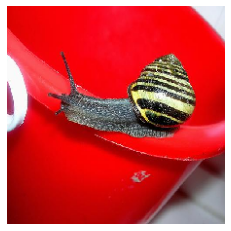

In [4]:
#Image path: 실습 image 3개
#image_path = './BIML_xai/appenzeller.jpg'
image_path = './BIML_xai/snail.jpg'

img = image.load_img(image_path, target_size = (224,224))
plt.imshow(img)
plt.axis('off')
plt.show()

### 이미지를 모델의 입력 형태로 변환 (전처리)

In [5]:
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=resnet50.preprocess_input(x)

### 모델 예측 결과 출력
### - 모델 예측 확률 기준, top-k에 해당하는 class 출력

In [8]:
#모델 예측
preds= model.predict(x)

#모델 예측 결과 출력 (top-k)
top_k = 4
prediction_results = resnet50.decode_predictions(preds,top=top_k)[0]
top_k_idx_list = preds[0].argsort()[::-1][:top_k]
for k in range(top_k):
    print('Top-',k+1,'예측 결과')
    print('예측 class : ',prediction_results[k][1])
    print('예측 clss index : ',top_k_idx_list[k])
    print('예측 확률 : ',prediction_results[k][2])
    print('\n')

2024-02-21 07:45:37.023980: E tensorflow/stream_executor/cuda/cuda_dnn.cc:373] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2024-02-21 07:45:37.024076: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'resnet50/conv1_conv/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_105326/2461566092.py", line 2, in <cell line: 2>
      preds= model.predict(x)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1982, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1801, in predict_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1790, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1783, in run_step
      outputs = model.predict_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1751, in predict_step
      return self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'resnet50/conv1_conv/Conv2D'
DNN library is not found.
	 [[{{node resnet50/conv1_conv/Conv2D}}]] [Op:__inference_predict_function_4865]

In [9]:
top_k_idx_list

NameError: name 'top_k_idx_list' is not defined

# Grad-CAM 생성
### - 모델이 예측한 top-k class에 대해서 grad-cam 생성
### - top-k class에 대한 모델 예측 원인 분석

In [ ]:
#모델의 특징 추출 부분에서 마지막 층을 지정 (penultimate layer)
#특징 추출 부분만으로 구성된 model_1만들기
last_conv_layer = model.get_layer("conv5_block3_out") # User choice
model_1= keras.Model(model.inputs, last_conv_layer.output)

#분류 (전역평균풀링 또는 완전연결층) 부분만으로 구성된 model__2만들기
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = model.get_layer("avg_pool")(input_2)
x_2 = model.get_layer("predictions")(x_2)
model_2=keras.Model(input_2,x_2)

#GradientTape함수를 이용한 그레디언트 계산
with tf.GradientTape() as tape:
    output_1 = model_1(x) #Activation 정보 (forward)
    tape.watch(output_1) #마지막 층으로 미분하기 위한 준비
    preds = model_2(output_1) #모델 예측
    
    #모델 설명을 얻고자 하는 class index 설정
    class_id = top_k_idx_list[0] # top1: top_k_idx_list[0], top2: top_k_idx_list[1]
    output_2 = preds[:,class_id] #설정한 class의 예측 score

In [ ]:
grads = tape.gradient(output_2, output_1) #그레디언트 계산
alpha = tf.reduce_mean(grads,axis=(0,1,2)).numpy() # 중요도 계산
Activation = output_1.numpy()[0] #Activation 정보

cam = np.sum(alpha * Activation,axis=2) #Linear combination
cam = np.maximum(cam, 0) #ReLu

#Min-Max scaling
cam = cam - np.min(cam)
cam = cam / np.max(cam) +1e-8

#Resizing
cam = np.expand_dims(cam, axis=2)
cam = tf.squeeze(tf.image.resize(cam,(224,224))).numpy()

# Grad-CAM 시각화
### - 붉은색일수록 모델이 이미지 분류를 위해 중요하게 생각한 feature에 해당

In [ ]:
img = image.load_img(image_path, target_size = (224,224)) #원본 이미지

fig = plt.figure(figsize=(15, 15))
plt.subplots_adjust(bottom=0.01)

plt.subplot(2,3,1)
plt.imshow(img)
plt.axis("off")
plt.title('Image')

#Grad-CAM 결과
plt.subplot(2,3,2)
plt.imshow((cam),cmap='jet')
plt.imshow(img,alpha = 0.3)
plt.axis("off")
plt.title('Grad-CAM')
#plt.show()

#Libra-CAM 결과
libra_cam = np.load('./sample_data/snail_libra.npy') #Libra-CAM snali
#libra_cam = np.load('./sample_data/appenzeller_libra.npy') #Libra-CAM appenzeller
plt.subplot(2,3,3)
plt.imshow((libra_cam),cmap='jet')
plt.imshow(img,alpha = 0.3)
plt.axis("off")
plt.title('Libra-CAM')
plt.show()

# Quiz
## 아래 image에 대한 모델의 top-1,2 예측, 원인 분석 (Grad-cam 생성)
## hint- top1 class: zebra, top2 class : tusker (elephant)

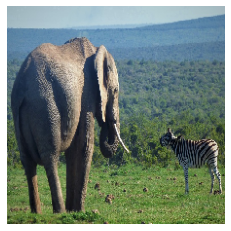

In [ ]:
image_path = './sample_data/zebra_and_elephant.jpg'

img = image.load_img(image_path, target_size = (224,224))
plt.imshow(img)
plt.axis('off')
plt.show()